In [ ]:
# Software Name : DistFactAssessLM
# SPDX-FileCopyrightText: Copyright (c) 2025 Orange SA
# SPDX-License-Identifier: GPL-2.0-or-later

# This software is distributed under the GNU General Public License v2.0 or later,
# see the "LICENSE.txt" file for more details or GNU General Public License v2.0 or later

# Authors: Hichem Ammar Khodja
# Software description: A factual knowledge assessment method for large language models using distractors

In [ ]:
# Plot 2 : Temp+IDF vs. IDF

%cd ../../src
import os
os.environ['AZURE_OPENAI_API_KEY'] = "[APIKEY]"
from kb.wikidata import TempWikidata, WikidataPrepStage
import pandas as pd
import pickle
import os.path as osp

DATE = "20210104"
a = TempWikidata(DATE, WikidataPrepStage.PREPROCESSED)

/opt/conda/envs/wfd_build/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/workspace/src


In [2]:
iter0 = pickle.load(open('/wfd_build_storage/optimize_know_evals_results/iteration_0.pkl', 'rb'))
iter1 = pickle.load(open('/wfd_build_storage/optimize_know_evals_results/iteration_1.pkl', 'rb'))
iter2 = pickle.load(open('/wfd_build_storage/optimize_know_evals_results/iteration_2.pkl', 'rb'))
iter3 = pickle.load(open('/wfd_build_storage/optimize_know_evals_results/iteration_3.pkl', 'rb'))

/opt/conda/envs/wfd_build/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from kb.core import Entity, Relation, Triple
from utils.general import load_json

wd = TempWikidata(DATE, WikidataPrepStage.PREPROCESSED)
raw_wd = TempWikidata(DATE, WikidataPrepStage.ALMOST_RAW)
temp = load_json('know/MinKAssess/wikidata_triples_to_human_scores.json')
triple2score = []
entities = []
for k,v in temp:
    sub_id, rel_id, obj_id = k
    triple = Triple(Entity(sub_id), Relation(rel_id), Entity(obj_id))
    triple2score.append((triple, v))
    entities.append(triple.subject)
    entities.append(triple.object)
wd.inject_info(triple2score)
trip2score = [(x,y) for x,y in triple2score if x.subject._label is not None and x.object._label is not None]
tripset = set(x for x,_ in trip2score)

In [3]:
import numpy as np
from sklearn.metrics import f1_score

def find_optimal_threshold(continuous_array, binary_array):
    # Ensure the arrays are numpy arrays for efficient computation
    continuous_array = np.array(continuous_array)
    binary_array = np.array(binary_array)
    
    # Get unique values from the continuous array to use as potential thresholds
    unique_values = np.unique(continuous_array)
    
    best_threshold = None
    max_f1 = -1
    
    for threshold in unique_values:
        # Binarize the continuous array using the current threshold
        binarized_array = continuous_array > threshold
        
        # Calculate the number of matches with the binary array
        f1 = f1_score(binarized_array, binary_array)
        
        # Update the best threshold if the current one has more matches
        if f1 > max_f1:
            max_f1 = f1
            best_threshold = threshold
    
    return best_threshold, max_f1


import numpy as np
from sklearn.model_selection import KFold
from scipy.stats import kendalltau


def cross_val_kendalltau_correlation(ground_truth, predicted_values, n_splits=10, random_state=42, n_repetitions=1):
    """
    Compute cross-validation Pearson correlation on the given data with specified number of folds.

    Parameters:
    ground_truth (array-like): Array of ground truth values.
    predicted_values (array-like): Array of predicted values.
    n_splits (int): Number of folds for cross-validation. Default is 10.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    mean_corr (float): Mean Pearson correlation across all folds.
    std_corr (float): Standard deviation of Pearson correlation across all folds.
    """
    # Convert inputs to numpy arrays
    ground_truth = np.array(ground_truth)
    predicted_values = np.array(predicted_values)

    # Ensure the arrays are of the same length
    assert len(ground_truth) == len(predicted_values), "Arrays must be of the same length"

    

    # List to store Pearson correlation coefficients
    taus_train = []
    taus_test = []
    p_train = []
    p_test = []
    # f1s = []
    # ths = []
    for i in range(n_repetitions):
        # Perform K-Fold cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state+i)
        for train_index, test_index in kf.split(ground_truth):
            # Compute Pearson correlation on the test set
            corr, p = kendalltau(ground_truth[train_index], predicted_values[train_index])
            taus_train.append(corr)
            p_train.append(p)

            # Compute Pearson correlation on the test set
            corr, p = kendalltau(ground_truth[test_index], predicted_values[test_index])
            taus_test.append(corr)
            p_test.append(p)


            # th, f1 = find_optimal_threshold(predicted_values[test_index], ground_truth[test_index] > 0.5)
            # ths.append(th)
            # f1s.append(f1)
            # assert 1 >= f1 >= 0

    # Convert to numpy array for easy computation of mean and std
    taus_test = np.array(taus_test)
    taus_train = np.array(taus_train)

    # ths = np.array(ths)
    # f1s = np.array(f1s)

    return taus_train, taus_test, p_train, p_test

In [4]:
from sklearn.model_selection import train_test_split

N_SPLITS = 3


ground_truth = np.array([y for _,y in trip2score])
columns = ['know_measure', 'n_distractors', 'agg', 'dist_finder', 'kendalltau_folds_train', 'kendalltau_folds_test', 
           'p_values_train', 'p_values_test', 'num_invalid', 'execution_time', 'num_beams', 'n', 'use_custom_templates', 'num_verbs', 'verbs_max']

In [53]:
import random
import numpy as np


from know.core import LogMeanMetric, MeanMetric, PosMetric, StrictMetric, WeightMetric
n_distractors_range = np.arange(1,201)
to_test = np.array([1,2,5,10] + list(range(20,201,20)))
aggs = [MeanMetric(n_distractors_range), PosMetric(n_distractors_range), 
        LogMeanMetric(n_distractors_range), StrictMetric(n_distractors_range), WeightMetric(n_distractors_range)]
np.random.seed(1234)

bin_ground_truth = ground_truth < 0.5
data = []
for dist_find, iter in (('idf', iter1), ('temp_idf', iter1), ('random', iter2), ('AoOD', iter3)):
    mean_execution_time = [res.additional_data['execution_time'] for res in iter]
    for n_distractors in n_distractors_range:
        for agg in aggs:
            for n_verbs in range(1,6):
                agg_name = agg.__class__.__name__.split('.')[-1]
                scores = []
                for res in iter:
                    tr = res.temp[0].triple
                    if tr not in tripset:
                        print('Skipping ', tr)
                        continue
                    res = np.array([agg.compute(true, np.array(x, dtype=np.float32)) 
                                    for true, x in zip(res.cred_true, res.cred_dist)], 
                                    dtype=np.float32)
                    max_verbs = len(res)
                    shuf = np.arange(max_verbs)
                    np.random.shuffle(shuf)
                    res = res[shuf]
                    res = res[:n_verbs]
                    res = res.mean(0)[:n_distractors]
                    for i in range(len(res)-1):
                        if np.isnan(res[i+1]):
                            break
                    else:
                        i = -1
                    scores.append(res[i])

                scores = np.array(scores)
                mask = ~np.isnan(scores)
                taus_train, taus_test, p_train, p_test = cross_val_kendalltau_correlation(ground_truth[mask], scores[mask], n_splits=N_SPLITS)
                data.append(('Distractors', n_distractors, agg_name, dist_find, taus_train, taus_test, p_train, p_test, mask.sum(), np.mean(mean_execution_time), None, None, None, n_verbs, max_verbs))

In [5]:
# pickle.dump(data, open('cross_eval_res.pkl', 'wb'))
data = pickle.load(open('cross_eval_res.pkl', 'rb'))

# Other approaches


In [6]:
folder = '/wfd_build_storage/optimize_know_evals_results'
import os
import os.path as osp
import pickle
import random
import re
random.seed(2163817)
from utils.general import dotdict

iters = []

for filename in os.listdir(folder):
    if int(re.match(r'^iteration_([0-9]+?)\.pkl$', filename).group(1)) < 4:
        continue
    iters.append(pickle.load(open(osp.join(folder, filename), 'rb')))

# Adding random knowledge measure

iter = [dotdict({
    'result' : random.random(),
    'know_measure_info' : {
        'cls': "know.RandomKM"
    },
    'additional_data' : {
        'execution_time' : 0
    }
}) for _ in range(len(trip2score))]
iters.append(iter)

/opt/conda/envs/wfd_build/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
np.random.seed(1234)

for iter in iters:
    for n_verbs in range(1,6):
        try:
            method = iter[0].know_measure_info['cls'].split('.')[-1]
        except KeyError:
            method = 'LogProb'
        num_beams = iter[0].know_measure_info.get('num_beams', None)
        n = iter[0].know_measure_info.get('n', None)
        use_custom_templates = iter[0].know_measure_info.get('using_custom_relations', None)
        scores = []
        execution_times = []
        for res in iter:
            if 'individual_results' in res.additional_data:
                indiv_res = np.array(res.additional_data['individual_results'])
                max_verbs = len(indiv_res)
                shuf = np.arange(max_verbs)
                np.random.shuffle(shuf)
                indiv_res = indiv_res[shuf]
                indiv_res = indiv_res[:n_verbs]
                s = np.mean(indiv_res)
            else:
                max_verbs = 'unk'
                s = res.result
            scores.append(s)
            execution_times.append(res.additional_data['execution_time'])
        scores = np.array(scores)
        mask = ~np.isnan(scores)
        taus_train, taus_test, p_train, p_test = cross_val_kendalltau_correlation(ground_truth[mask], scores[mask], n_splits=N_SPLITS)
        data.append((method, None, None, None, taus_train, taus_test, p_train, p_test, mask.sum(), np.mean(execution_times), num_beams,n, use_custom_templates, n_verbs, max_verbs))
        if method == 'KaRR':
            # We cannot split verbalizations in KaRR
            break
    

In [8]:
df = pd.DataFrame(data, columns=columns)
df['fold_id'] = df['kendalltau_folds_test'].apply(lambda x : list(range(len(x))))

In [9]:
df_opt =  df[(df['verbs_max'] == df['num_verbs']) & np.isin(df['agg'], ['StrictMetric', 'MeanMetric', None]) & (np.isin(df["n_distractors"], [1,2,5,10] + list(range(20,201,20))) | df['n_distractors'].isna())] \
            .sort_values('n_distractors', ascending=False)\
            .sort_values("n", ascending=False)\
            .sort_values("num_beams", ascending=False)
df_opt = df_opt.explode(['kendalltau_folds_test', 'kendalltau_folds_train', 'fold_id']).reset_index()
df_opt[['kendalltau_folds_test', 'kendalltau_folds_train']] = df_opt[['kendalltau_folds_test', 'kendalltau_folds_train']].astype(float)
idx = df_opt.groupby(['know_measure', 'dist_finder', 'use_custom_templates', 'fold_id'], dropna=False)['kendalltau_folds_train'].idxmax(skipna=True)
idx = idx[~idx.isna()]
df_opt = df_opt.loc[idx]

# Table: Human alignment of each studied knowledge measure

In [10]:
# Print score table

cross_val_scores = df_opt.groupby(['know_measure', 'dist_finder', 'use_custom_templates'], dropna=False)['kendalltau_folds_test'].mean()
cross_val_std = df_opt.groupby(['know_measure', 'dist_finder', 'use_custom_templates'], dropna=False)['kendalltau_folds_test'].std()
cross_val_std.name = 'std'
cross_val_scores.name = 'mean'
cross_val = pd.concat([cross_val_scores, cross_val_std], axis=1)
cross_val['measure_name'] = (pd.Series([x[0] for x in cross_val_scores.index.tolist()]) + pd.Series([x[1] for x in cross_val_scores.index.tolist()]).astype(str).apply(lambda x : '' if str(x) == 'nan' else '_' + str(x))).tolist()

distfind2name = {
    'AoOD' : 'ApprOpt',
    'idf' : 'Sem',
    'temp_idf' : 'Temp+Sem',
    'random' : 'Random'
}

know_measure2name = {
    'BERTScoreKM' : 'BERT-Score',
    'LogProb' : 'Probability',
    'RougeLKnowMeasure' : 'ROUGE-L',
    'LLMAsAJudgeKM' : 'LLM-as-a-judge',
    'PrecisionAtN' : 'Precision@$n$' ,
    'GreddyCheck' : 'Greedy-check'
}

def f(x : str):
    if x.startswith('Distractors'):
        name, dist = x.split('_', 1)
        return 'Dist.' + ' ' + distfind2name[dist]
    return know_measure2name.get(x, x)

s = cross_val[['measure_name', "mean", "std"]].reset_index(drop=True).sort_values('mean')
s['measure_name'] = s['measure_name'].apply(f)

s.columns = ['Know. measure', "Mean $\\tau$", "Std $\\tau$"]
print(s.to_latex(index=False, float_format='%.3f'))

\begin{tabular}{lrr}
\toprule
Know. measure & Mean $\tau$ & Std $\tau$ \\
\midrule
ROUGE-L & 0.138 & 0.122 \\
BERT-Score & 0.159 & 0.063 \\
Precision@$n$ & 0.185 & 0.028 \\
Dist. Random & 0.225 & 0.021 \\
Dist. Sem & 0.242 & 0.023 \\
Dist. Temp+Sem & 0.242 & 0.023 \\
Probability & 0.262 & 0.047 \\
Dist. ApprOpt & 0.282 & 0.024 \\
LLM-as-a-judge & 0.293 & 0.029 \\
\bottomrule
\end{tabular}



In [11]:
# Print best configurations table
import math


know_measure2name = {
    'BERTScoreKM' : 'BERT-Score',
    'LogProb' : 'Probability',
    'RougeLKnowMeasure' : 'ROUGE-L',
    'LLMAsAJudgeKM' : 'LLM-as-a-judge',
    'PrecisionAtN' : 'Precision@$n$' ,
    'GreddyCheck' : 'Greedy-check',
    'Distractors' : 'Dist.'
}
distfind2name = {
    'AoOD' : 'ApprOpt',
    'idf' : 'Sem',
    'temp_idf' : 'Temp+Sem',
    'random' : 'Random'
}
agg2name = {
    'StrictMetric' : 'Min@$n$'
}
def f(x):
    if math.isnan(x):
        return ''
    return int(x)
a = df_opt.copy()
a['know_measure'].replace(know_measure2name, inplace=True)
a['agg'].replace(agg2name, inplace=True)
a['dist_finder'].replace(distfind2name, inplace=True)
a['num_beams'] = a['num_beams'].apply(f)
a['n_distractors'] = a['n_distractors'].apply(f)
a['n'] = a['n'].apply(f)
a['kendalltau_folds_test'] = a['kendalltau_folds_test'].apply(lambda x : "%.2f" % x)
cols = ["know_measure",	"dist_finder", "agg", "n_distractors", "num_beams",	"n", "kendalltau_folds_test"]
a = a[cols]
# a = a.groupby(cols[:-1], dropna=False).aggregate(lambda x : ).reset_index()
cols2 = ['Know. measure', 'Retr. strategy', 'Agg.',"Num. distractors",  "Beam width", '$k$', "$\\tau$"]
a.columns = cols2
a = a.fillna('')
a = a.set_index(cols2)
print(a.to_latex())

\begin{tabular}{lllllll}
\toprule
Know. measure & Retr. strategy & Agg. & Num. distractors & Beam width & $k$ & $\tau$ \\
\midrule
\multirow[t]{3}{*}{BERT-Score} & \multirow[t]{3}{*}{} & \multirow[t]{3}{*}{} & \multirow[t]{3}{*}{} & 100 &  & 0.21 \\
\cline{5-7} \cline{6-7}
 &  &  &  & 1 &  & 0.09 \\
\cline{5-7} \cline{6-7}
 &  &  &  & 2 &  & 0.17 \\
\cline{1-7} \cline{2-7} \cline{3-7} \cline{4-7} \cline{5-7} \cline{6-7}
\multirow[t]{12}{*}{Dist.} & \multirow[t]{3}{*}{ApprOpt} & \multirow[t]{3}{*}{Min@$n$} & \multirow[t]{3}{*}{200} & \multirow[t]{3}{*}{} & \multirow[t]{3}{*}{} & 0.31 \\
 &  &  &  &  &  & 0.26 \\
 &  &  &  &  &  & 0.27 \\
\cline{2-7} \cline{3-7} \cline{4-7} \cline{5-7} \cline{6-7}
 & \multirow[t]{3}{*}{Sem} & \multirow[t]{3}{*}{Min@$n$} & 80 &  &  & 0.22 \\
\cline{4-7} \cline{5-7} \cline{6-7}
 &  &  & 200 &  &  & 0.27 \\
\cline{4-7} \cline{5-7} \cline{6-7}
 &  &  & 120 &  &  & 0.24 \\
\cline{2-7} \cline{3-7} \cline{4-7} \cline{5-7} \cline{6-7}
 & \multirow[t]{3}{*}{Rando

/tmp/ipykernel_307700/2967379479.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  a['know_measure'].replace(know_measure2name, inplace=True)
/tmp/ipykernel_307700/2967379479.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

# Figure: Relation between the number of distractors and the correlation with human judgement 

/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

  dist_finder  PearsonCorr         PValue
0        AoOD     0.193359   1.273088e-16
1      random     0.648509  2.535277e-215
2    temp_idf     0.545557  3.970069e-140


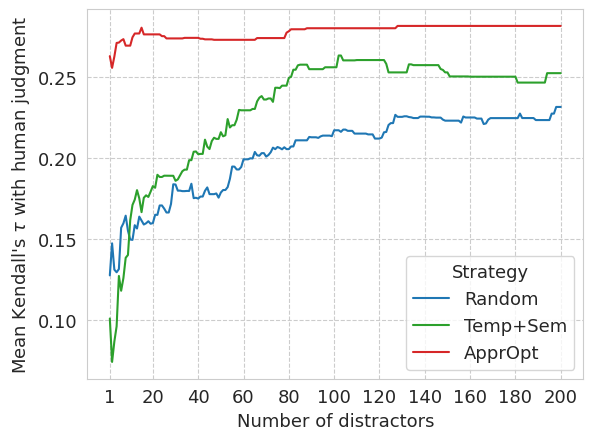

In [12]:
# Correlation between the number of distractors and human judgment
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

dist_cols = cols[:-1].copy()
dist_cols.remove('n_distractors')
ndist_corr = df[(df['know_measure'] == 'Distractors') & (df['num_verbs'] == 5)].merge(df_opt, on=dist_cols)
ndist_corr = ndist_corr.explode('kendalltau_folds_test_x')

# Plotting
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.rcParams.update({'font.size': 13})
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['pdf.fonttype'] = 42  # Ensures that fonts are embedded as Type 42 (TrueType)
ndist_corr['Strategy'] = ndist_corr['dist_finder'].replace({
    'temp_idf' : 'Temp+Sem',
    'idf' : 'Sem',
    'random' : 'Random',
    'AoOD' : 'ApprOpt'
})
ndist_corr = ndist_corr[ndist_corr['Strategy'] != 'Sem'] 
default_palette = sns.color_palette()
sns.lineplot(ndist_corr, x='n_distractors_x', y='kendalltau_folds_test_x', hue='Strategy', 
             errorbar=None, hue_order=['Random', 'Temp+Sem', 'ApprOpt'],
             palette=[default_palette[0]] + default_palette[2:4])
plt.xlabel("Number of distractors")
plt.ylabel("Mean Kendall's $\\tau$ with human judgment")

plt.xticks([1,20,40,60,80,100,120,140,160,180,200])



def pearson_corr(group):
    corr, p_value = scipy.stats.pearsonr(group['n_distractors_x'], group['kendalltau_folds_test_x'])
    return pd.Series({'PearsonCorr': corr, 'PValue': p_value})

# Step 3: Group by the 'Category' column
grouped = ndist_corr.groupby('dist_finder')

# Step 4: Apply the function to each group
result = grouped.apply(pearson_corr).reset_index()
print(result)

plt.savefig("n_distractors_vs_corr.pdf", bbox_inches='tight', pad_inches=0)


# Figure: Relation between the number of verbalizations and the correlation with human judgement

Index(['know_measure', 'n_distractors', 'agg', 'dist_finder',
       'kendalltau_folds_train', 'kendalltau_folds_test', 'p_values_train',
       'p_values_test', 'num_invalid', 'execution_time', 'num_beams', 'n',
       'use_custom_templates', 'num_verbs', 'verbs_max', 'fold_id', 'index',
       'kendalltau_folds_train_x', 'kendalltau_folds_test_x',
       'p_values_train_x', 'p_values_test_x', 'num_invalid_x',
       'execution_time_x', 'use_custom_templates_x', 'num_verbs_x',
       'verbs_max_x', 'fold_id_x', 'kendalltau_folds_train_gain',
       'kendalltau_folds_test_gain', 'p_values_train_gain',
       'p_values_test_gain', 'num_invalid_gain', 'execution_time_gain',
       'use_custom_templates_gain', 'num_verbs_gain', 'verbs_max_gain',
       'fold_id_gain'],
      dtype='object')


/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

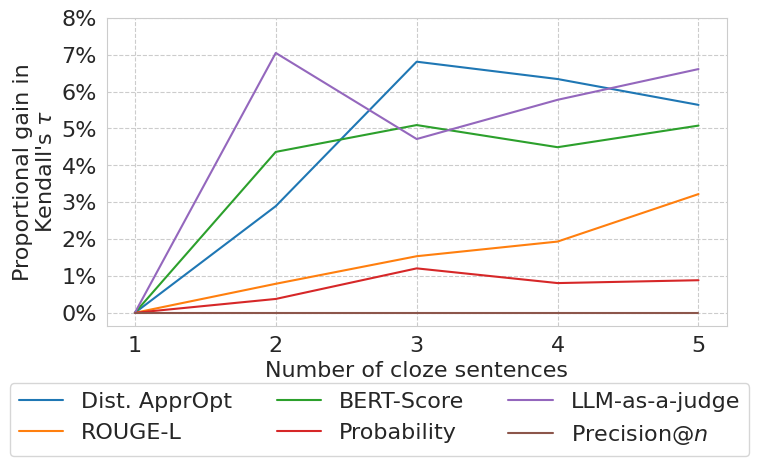

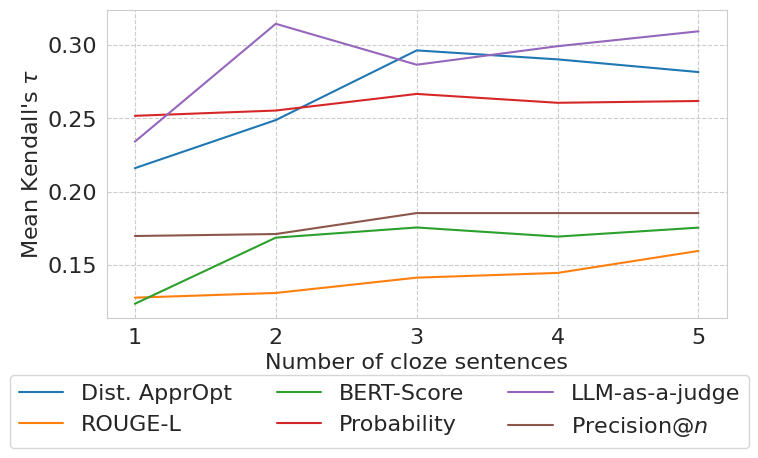

In [14]:
# Correlation between the number of cloze sentences and human judgment
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

verb_cols = cols[:-1].copy()
nverb_corr = df.merge(df_opt, on=verb_cols, suffixes=('', '_x'))
nverb_corr = nverb_corr.merge(df[df['num_verbs'] == 1], on=verb_cols, suffixes=('', '_gain'))
nverb_corr = nverb_corr[np.isin(nverb_corr['dist_finder'], ['AoOD', None])]
nverb_corr = nverb_corr.explode(['kendalltau_folds_test', 'kendalltau_folds_test_gain'])
print(nverb_corr.columns)

# Plotting

distfind2name = {
    'AoOD' : 'ApprOpt',
    'idf' : 'Sem',
    'temp_idf' : 'Temp+Sem',
    'random' : 'Random'
}

know_measure2name = {
    'BERTScoreKM' : 'BERT-Score',
    'LogProb' : 'Probability',
    'RougeLKnowMeasure' : 'ROUGE-L',
    'PrecisionAtN' : 'Precision@$n$',
    'LLMAsAJudgeKM' : 'LLM-as-a-judge',
    'Distractors' : 'Dist.'
}

nverb_corr['Knowledge measure'] = nverb_corr['know_measure'].apply(lambda x : know_measure2name.get(x,x)) + nverb_corr['dist_finder'].apply(lambda x : '' if x is None else ' ' + distfind2name[x])
nverb_corr['Gain'] = (nverb_corr['kendalltau_folds_test'] +1) / (nverb_corr['kendalltau_folds_test_gain'] +1)
nverb_corr = nverb_corr.reset_index()

sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['pdf.fonttype'] = 42  # Ensures that fonts are embedded as Type 42 (TrueType)
plt.figure(figsize=(8,4))
fig = sns.lineplot(nverb_corr, x='num_verbs', y='Gain', hue='Knowledge measure', errorbar=None)
plt.xlabel('Number of cloze sentences')
plt.xticks([1,2,3,4,5])
plt.ylabel("Proportional gain in\nKendall's $\\tau$")
plt.yticks(ticks=[i for i in np.arange(1.0,1.081,0.01)],  labels=[f'{i}%' for i in range(0,9)])
plt.legend(loc='upper center', bbox_to_anchor=(0.44, -0.15), ncol=3)
plt.savefig("num_verbalization1.pdf", bbox_inches='tight', pad_inches=0)

plt.figure(figsize=(8,4))
fig = sns.lineplot(nverb_corr, x='num_verbs', y='kendalltau_folds_test', hue='Knowledge measure', errorbar=None)
plt.xlabel('Number of cloze sentences')
plt.ylabel("Mean Kendall's $\\tau$")
plt.xticks([1,2,3,4,5])
plt.legend(loc='upper center', bbox_to_anchor=(0.44, -0.15), ncol=3)

plt.savefig("num_verbalization2.pdf", bbox_inches='tight', pad_inches=0)

# Robsutness to verbalization errors

In [6]:
# Robustness to verbalization errors
from kb.core import TripleComp
from know.core import CredKnowMeasure
from lm.core import LogProbability

km = CredKnowMeasure(LogProbability(), compute_on=TripleComp.OBJECT)

/opt/conda/envs/wfd_build/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from verb.core import Template

raw_wd = TempWikidata(DATE, WikidataPrepStage.ALMOST_RAW)
def f(x):
    m = re.match(r"^\('(.+?)', '(.+?)', '(.+?)'\)$", x)
    subject = Entity(m.group(1))
    relation = Relation(m.group(2))
    object = Entity(m.group(3))
    return Triple(subject, relation, object)

import re

def replace_phrases(text, replacements):
    # Sort replacements by length of the key in descending order to handle nested replacements
    sorted_replacements = sorted(replacements.items(), key=lambda item: -len(item[0]))
    
    # Create a temporary placeholder for each replacement to avoid conflicts
    placeholders = {key: f"__PLACEHOLDER_{i}__" for i, (key, _) in enumerate(sorted_replacements)}
    
    # Replace each key with its placeholder
    for key, placeholder in placeholders.items():
        text = re.sub(re.escape(key), placeholder, text)
    
    # Replace each placeholder with its final replacement
    for key, placeholder in placeholders.items():
        text = text.replace(placeholder, replacements[key])
    
    return text

def g(x):
    tr = x['triples']
    to_replace = {
        tr.subject.label:'[SUB]', tr.object.label:'[OBJ]'
    }
    
    temp = replace_phrases(x['verbalization'], to_replace)
    temp = Template.from_string(temp, tr.relation).inject(tr.subject, tr.object)
    return temp

def h(x):
    tr = x['triples']
    to_replace = {
        tr.subject.label:'[SUB]', tr.object.label:'[OBJ]'
    }
    
    temp = replace_phrases(x['correction'].rstrip('”').replace('“', '« '), to_replace)
    temp = Template.from_string(temp, tr.relation).inject(tr.subject, tr.object)
    return temp

df = pd.read_csv('../scripts/taxonomy/taxonomy_hichem.csv', index_col=0)
df = df.iloc[:152]
df = df[df['errors'].str.len() > 0]
df = df[df['errors'] != 'ignore']
df['errors'] = df['errors'].apply(lambda x : ['perfect'] if x == '-' else x.replace(' ', '').split(','))
df = df[df['context'] == 'present']
df = df[df['errors'].apply(lambda x : x != ['perfect'])]

df['triples'] = df['triples_raw'].apply(f)
raw_wd.inject_info(df['triples'].tolist())

df['template'] = df.apply(g, axis=1)
df['correct'] = df.apply(h, axis=1)
def f(temp : Template):
    if temp.ends_with is None:
        return None
    if temp.ends_with == TripleComp.SUBJECT:
        t = Template.from_string(temp._template.replace('[SUB]', '[TEMP]').replace('[OBJ]', '[SUB]').replace('[TEMP]','[OBJ]'), temp.relation)
        t.inject(temp.triple.object, temp.triple.subject)
        return t
    return temp
df['template'] = df['template'].apply(f)
df['correct'] = df['correct'].apply(f)
df = df[~(df['template'].isna() | df['correct'].isna())]

In [8]:
from lm.core import LanguageModel


lm = LanguageModel.from_pretrained_name('gpt2-xl', 'auto')

/opt/conda/envs/wfd_build/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
pd.reset_option('max_columns')
pd.set_option('display.max_colwidth',3000)
df[['template', 'correct']]

,template,correct
0,1951 Neutral Bay state by-election is a by-election,The 1951 Neutral Bay state by-election is a by-election
2,pyrotechnical machine is responsible for El Dorado Fire,A pyrotechnical machine is responsible for El Dorado Fire
4,Nikhil Dwivedi is part of the cast of Scam 1992: The Harshad Metha story,Nikhil Dwivedi is part of the cast of « Scam 1992: The Harshad Metha story
14,The language uses in Nigeria is Koenoem,One language used in Nigeria is Koenoem
16,Iconha River is an example of a river,The Iconha River is an example of a river
18,Barna Hedenhös is created in Sweden,Barna Hedenhös was created in Sweden
20,2020 Nashville bombing is executed by Anthony Quinn Warner,The 2020 Nashville bombing was executed by Anthony Quinn Warner
24,United Kingdom is the home country of Matchbox,The United Kingdom is the home country of Matchbox
28,University of the South Pacific confers a Master of Laws,The University of the South Pacific confers a Master of Laws
30,The American Music Award for Favorite Pop/Rock Band/Duo/Group is received by Fleetwood Mac,The American Music Award for Favorite Pop/Rock Band/Duo/Group was received by Fleetwood Mac


In [9]:
df['template'].iloc[0].copy()

1951 Neutral Bay state by-election is a by-election

In [ ]:
from know.core import DistKnowMeasure
from know.distractor_find import ApproxIdealDistractorFinder, RandomDistractorFinder, SimilarityDistractorFinder
from know.generation import BERTScoreKM, LLMAsAJudgeKM, PrecisionAtN, RougeLKnowMeasure


def iterate_know_measures():
    
    logprob = LogProbability()

    for _ in range(N_SPLITS):
        yield CredKnowMeasure(logprob, compute_on=TripleComp.OBJECT)

    dist_finders = [
        (SimilarityDistractorFinder(DATE), StrictMetric([80,200,120])),
        (SimilarityDistractorFinder(DATE, use_temporal_distractors=True), StrictMetric([80,200,120])),
        (RandomDistractorFinder(wd), StrictMetric([200,200,180])),
        (ApproxIdealDistractorFinder(wd, lm), StrictMetric([200,200,200]))
    ]
    for dist_find, agg in dist_finders:
        dist_find.load()
        know_measure = DistKnowMeasure(agg, dist_find, logprob, compute_cred_on_object=True, use_aliases=True)
        yield know_measure

    for num_beams in [100,1,2]:
        yield BERTScoreKM(raw_wd, num_beams)
    for num_beams in [100,1,1]:
        yield RougeLKnowMeasure(raw_wd, num_beams)


    for n in [100,100,100]:
        yield PrecisionAtN(raw_wd, n)
    for num_beams in [1,2,2]:
        yield LLMAsAJudgeKM(raw_wd, num_beams, oai_model="gpt-35-turbo-16k-0613")

    

In [41]:
from tqdm import tqdm
from know.core import DistKnowAggMetric, DistKnowMeasure, StrictMetric, MeanMetric
from know.distractor_find import ApproxIdealDistractorFinder

res_error = []
res_correct = []

for km in iterate_know_measures():
    for temp in tqdm(df['template']):
        try:
            res = km.measure_temp(lm,temp)
        except Exception as e:
            print(e)
            res = None
        res_error.append(res)
    
    for temp in tqdm(df['correct']):
        try:
            res = km.measure_temp(lm,temp)
        except Exception as e:
            print(e)
            res = None
        res_correct.append(res)


  3%|▎         | 1/32 [00:00<00:03,  8.74it/s]

100%|██████████| 32/32 [00:01<00:00, 22.04it/s]


Getting index and co. from another instance of SimilarityDistractorFinder...


 19%|█▉        | 6/32 [00:09<01:08,  2.62s/it]

expect CSR matrix here


 31%|███▏      | 10/32 [00:12<00:25,  1.17s/it]

expect CSR matrix here
expect CSR matrix here


 59%|█████▉    | 19/32 [00:30<00:42,  3.27s/it]

expect CSR matrix here
expect CSR matrix here


 19%|█▉        | 6/32 [00:09<01:07,  2.61s/it]

expect CSR matrix here


 31%|███▏      | 10/32 [00:12<00:25,  1.16s/it]

expect CSR matrix here
expect CSR matrix here


 59%|█████▉    | 19/32 [00:30<00:42,  3.28s/it]

expect CSR matrix here
expect CSR matrix here


100%|██████████| 32/32 [00:46<00:00,  1.45s/it]


Getting index and co. from another instance of SimilarityDistractorFinder...


 19%|█▉        | 6/32 [00:09<01:07,  2.58s/it]

expect CSR matrix here


 31%|███▏      | 10/32 [00:11<00:25,  1.15s/it]

expect CSR matrix here
expect CSR matrix here


 59%|█████▉    | 19/32 [00:30<00:42,  3.25s/it]

expect CSR matrix here
expect CSR matrix here


 19%|█▉        | 6/32 [00:09<01:07,  2.60s/it]

expect CSR matrix here


 31%|███▏      | 10/32 [00:12<00:25,  1.16s/it]

expect CSR matrix here
expect CSR matrix here


 59%|█████▉    | 19/32 [00:30<00:42,  3.29s/it]

expect CSR matrix here
expect CSR matrix here


100%|██████████| 32/32 [00:42<00:00,  1.34s/it]


Loading ApproxIdealDistractorFinder...
Load label2entity : 14.896551132202148 sec
Load type2entity : 13.188313007354736 sec
Build parser for each type : 229.4664969444275 sec
Loading finished. 257.55sec


  0%|          | 0/32 [00:00<?, ?it/s]/opt/conda/envs/wfd_build/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  3%|▎         | 1/32 [00:03<02:00,  3.88s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  6%|▋         | 2/32 [00:06<01:3

In [ ]:
# Use this for caching
with open('robust_data.pkl', 'wb') as f:
    pickle.dump((res_correct, res_error), f)

# res_correct, res_error = pickle.load(open('robust_data.pkl', 'rb'))

In [36]:
from collections import defaultdict
import math

data_rob = []

def get_dist_find(info : dict):
    if 'dist_finder' not in info:
        return None
    if "know.distractor_find.SimilarityDistractorFinder" == info['dist_finder']['cls']:
        if info['dist_finder']['use_temporal_distractors']:
            return "Temp+Sem"
        else:
            return "Sem"
    elif "know.distractor_find.RandomDistractorFinder" == info['dist_finder']['cls']:
        return "Random"
    elif "know.distractor_find.ApproxIdealDistractorFinder" == info['dist_finder']['cls']:
        return "ApprOpt"
    print(info)
    raise Exception

count = defaultdict(int)
columns = ["know_measure",	"dist_finder", "agg", "n_distractors", "num_beams",	"n", "fact_id", "fold_id", 'value_correct', 'value_error']
for i in range(0, len(res_correct), len(df)):
    resc, rese = res_correct[i:i+len(df)], res_error[i:i+len(df)]
    info = resc[0].know_measure_info
    dist_find = get_dist_find(info)
    print(dist_find)
    if dist_find != 'ApprOpt' and dist_find is not None:
        continue
    knowname = info.get('cls', 'LogProb')
    for k, rc, re in zip(range(len(resc)),resc, rese):
        rc = rc.result if rc is not None else None
        re = re.result if re is not None else None
        if dist_find is not None:
            if rc is None:
                rc = [None]*N_SPLITS
            if re is None:
                re = [None]*N_SPLITS
            for j,n,vc,ve in zip(range(len(rc)), info['agg']['n'], rc, re):
                if j != 0:
                    continue
                data_rob.append((knowname, dist_find, 'Min@n', n, None, None, k, j, vc, ve))
        else:
            n = info.get('n')
            num_beams = info.get('num_beams')
            data_rob.append((knowname, None, None, None, num_beams, n, k, count[knowname],rc, re))
    count[knowname] += 1
df_rob = pd.DataFrame(data_rob, columns=columns)
df_rob = df_rob[df_rob['know_measure'] != "know.generation.PrecisionAtN"]

None
None
None
Sem
Temp+Sem
Random
ApprOpt
None
None
None
None
None
None
None
None
None
None
None
None


# Table: Robustness to verbalization artifacts

In [ ]:
def f(dataf : pd.DataFrame):
    vc, ve = dataf['value_correct'], dataf['value_error']
    mask = vc.isna() | ve.isna()
    return set((dataf.loc[~mask, "fact_id"]).tolist())

sets_valid_facts = df_rob.groupby(["know_measure",	"dist_finder", "agg", "n_distractors", "num_beams", "n", "fold_id"], dropna=False).apply(f)
valid_facts_overall = set(range(len(df)))
for s in sets_valid_facts:
    valid_facts_overall.intersection_update(s)
rob = df_rob[np.isin(df_rob['fact_id'], list(valid_facts_overall))]
# display(rob)

def tau(dataf : pd.DataFrame):
    def tau_(d):
        tau, p = kendalltau(d['value_correct'], d['value_error'])
        return pd.Series({'Kendall': tau, 'PValue': p})
    a = dataf.groupby('fold_id').apply(tau_)
    # display(a)
    # display(a.index)
    return pd.Series({'Kendall': a['Kendall'].mean(), 'PValue': a['PValue'].tolist(), 'Std' : a['Kendall'].std()})
rob = rob.groupby(["know_measure",	"dist_finder"], dropna=False).apply(tau)

rob = rob.reset_index()
rob['Know. Measure'] = (rob['know_measure'].astype(str) + rob['dist_finder'].astype(str)).replace({
    'know.generation.RougeLKnowMeasurenan' : 'ROUGE-L',
    'know.generation.BERTScoreKMnan' : 'BERT-Score',
    'LogProbnan' : 'Probability',
    'know.generation.LLMAsAJudgeKMnan' : 'LLM-as-a-judge',
    'know.core.DistKnowMeasureApprOpt' : 'Dist. ApprOpt'

})
rob = rob.sort_values('Kendall')
final_rob = rob.drop(columns=['PValue', 'Std', 'know_measure', 'dist_finder']).iloc[:,::-1]
display(final_rob)
print(final_rob.to_latex(index=False, float_format='%.2f'))

/tmp/ipykernel_275695/767729167.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sets_valid_facts = df_rob.groupby(["know_measure",	"dist_finder", "agg", "n_distractors", "num_beams", "n", "fold_id"], dropna=False).apply(f)


,know_measure,dist_finder,agg,n_distractors,num_beams,n,fact_id,fold_id,value_correct,value_error
0,LogProb,None,None,NaN,NaN,NaN,0,0,-11.9375,-13.62500
1,LogProb,None,None,NaN,NaN,NaN,1,0,-22.3750,-23.25000
2,LogProb,None,None,NaN,NaN,NaN,2,0,-65.0000,-67.00000
3,LogProb,None,None,NaN,NaN,NaN,3,0,-30.2500,-28.75000
5,LogProb,None,None,NaN,NaN,NaN,5,0,-5.6250,-4.59375
...,...,...,...,...,...,...,...,...,...,...
504,know.generation.LLMAsAJudgeKM,None,None,NaN,2.0,NaN,24,2,0.0000,0.00000
506,know.generation.LLMAsAJudgeKM,None,None,NaN,2.0,NaN,26,2,1.0000,0.00000
507,know.generation.LLMAsAJudgeKM,None,None,NaN,2.0,NaN,27,2,0.0000,0.00000
508,know.generation.LLMAsAJudgeKM,None,None,NaN,2.0,NaN,28,2,1.0000,0.00000


/tmp/ipykernel_275695/767729167.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a = dataf.groupby('fold_id').apply(tau_)


,Kendall,PValue
fold_id,,
0,0.625714,0.000005
1,0.625714,0.000005
2,0.625714,0.000005


Index([0, 1, 2], dtype='int64', name='fold_id')

/tmp/ipykernel_275695/767729167.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a = dataf.groupby('fold_id').apply(tau_)


,Kendall,PValue
fold_id,,
0,0.921954,0.000003


Index([0], dtype='int64', name='fold_id')

/tmp/ipykernel_275695/767729167.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a = dataf.groupby('fold_id').apply(tau_)


,Kendall,PValue
fold_id,,
0,0.703704,1.272512e-08
1,0.498575,1.622673e-04
2,0.635328,5.735377e-07


Index([0, 1, 2], dtype='int64', name='fold_id')

/tmp/ipykernel_275695/767729167.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a = dataf.groupby('fold_id').apply(tau_)


,Kendall,PValue
fold_id,,
0,0.846043,0.000016
1,0.452432,0.021057
2,0.452432,0.021057


Index([0, 1, 2], dtype='int64', name='fold_id')

/tmp/ipykernel_275695/767729167.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a = dataf.groupby('fold_id').apply(tau_)


,Kendall,PValue
fold_id,,
0,0.675214,6.881921e-08
1,0.367521,6.755799e-03
2,0.367521,6.755799e-03


Index([0, 1, 2], dtype='int64', name='fold_id')

\begin{tabular}{lr}
\toprule
Know. Measure & Kendall \\
\midrule
ROUGE-L & 0.47 \\
LLM-as-a-judge & 0.58 \\
BERT-Score & 0.61 \\
Probability & 0.63 \\
Dist. ApprOpt & 0.92 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_275695/767729167.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rob = rob.groupby(["know_measure",	"dist_finder"], dropna=False).apply(tau)
